Imports

In [1]:
import sys
sys.path.append("/home/sanketh/DANI/GraphMatching/")

In [2]:
import pathlib
import os
import numpy as np
import torch
from torch import optim
from subgraph_matching_via_nn.data.data_loaders import load_graph
from powerful_gnns.util import S2VGraph
from powerful_gnns.util import load_data_given_graph_list_and_label_map
from powerful_gnns.models.graphcnn import GraphCNN
from powerful_gnns.util import separate_data
from powerful_gnns.classifier_training import train, test
from common.EmbeddingCalculationsService import pairwise_l2_distance, show_distance_matrix, \
    calculate_energy_based_hidden_rep
from subgraph_matching_via_nn.training.PairSampleInfo import Pair_Sample_Info
from subgraph_matching_via_nn.data.annotated_graph import AnnotatedGraph
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import MLPGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.embedding_metric_nn import EmbeddingMetricNetwork
from subgraph_matching_via_nn.graph_embedding_networks.gnn_embedding_network import GNNEmbeddingNetwork
from subgraph_matching_via_nn.training.trainer.S2VGraphEmbeddingSimilarityMetricTrainer import \
    S2VGraphEmbeddingSimilarityMetricTrainer
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import SingleEmbeddingGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import S2VGraphEmbeddingGraphMetricNetwork
from networkx import NetworkXError
import itertools
from livelossplot import PlotLosses
import networkx as nx

In [3]:
def generate_s2v_graphs(networkx_graphs, print_stats=True):
    g_list = []
    label_dict = {}
    for networkx_graph in networkx_graphs:
        g_list.append(S2VGraph(networkx_graph, label=None))

        if not label in label_dict:
            mapped = len(label_dict)
            label_dict[label] = mapped

    graphs, _ = load_data_given_graph_list_and_label_map(g_list, label_dict, degree_as_tag=True, device=device, print_stats=print_stats)
    for s2v_graph in graphs:
        # convert graph features here, not only in trainer! (heatmap is probably wrong)
        annotated_graph = AnnotatedGraph(s2v_graph.g)
        s2v_graph.node_features = annotated_graph.node_indicator.to(device=device)

    return graphs

In [4]:
goal_subcircuit_name = 'alu'
DATA_PATH = 'C:/Users/kogan/OneDrive/Desktop/Research/AMIT/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
DATA_PATH = '../subgraph_matching_via_nn/data/subcircuits/'

desktop = pathlib.Path(DATA_PATH)
subgraphs = []
labels = []
for circuit_dir in desktop.iterdir():
    if circuit_dir.is_dir():
        for subcircuit_file in circuit_dir.iterdir():
            if subcircuit_file.is_file():
                file_name = subcircuit_file.name
                if file_name == 'full_graph.p':
                    file_rel_path = f"{os.sep}{file_name}"
                    loader_params = {
                     'data_path' : str(circuit_dir),
                     'g_full_path': file_rel_path,
                     'g_sub_path': file_rel_path}

                    sub_graph = \
                        load_graph(type='subcircuit',
                                   loader_params=loader_params)

                    if goal_subcircuit_name in circuit_dir.name:
                        labels.append(1)
                    else:
                        # continue #TODO?
                        labels.append(0)
                    subgraphs.append(sub_graph)

labels = np.array(labels, dtype='float32')
N = len(subgraphs)
N_training = int(2 / 3 * N)

In [5]:
subgraphs = []
labels = []

# circuit_base_dir = 'C:\\Users\\kogan\\OneDrive\\Desktop\\Research\\AMIT\\GraphMatching\\subgraph_matching_via_nn\\data\\subcircuits\\'
circuit_base_dir = '/home/sanketh/DANI/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'


for circuit_file_name in ['adder_4', 'alu_4', 'alu_8', 'alu_16', 'alu_32', 'mul_4_4', 'mul_4_8', 'mul_8_8', 'mul_16_16', 'mul_16_32']:
    file_rel_path = 'full_graph.p'
    circuit_dir = f"{circuit_base_dir}{circuit_file_name}{os.sep}"
    loader_params = {
     'data_path' : str(circuit_dir),
     'g_full_path': file_rel_path,
     'g_sub_path': file_rel_path}

    sub_graph = \
        load_graph(type='subcircuit',
                   loader_params=loader_params)
    subgraphs.append(sub_graph)
    labels.append(0)
labels[0] = 1

N = len(subgraphs)
N_training = int(2 / 3 * N)

Transform graphs into S2VGraph-s

In [6]:
g_list = []
label_dict = {}
for subgraph, label in zip(subgraphs, labels):
    g_list.append(S2VGraph(subgraph.G, label))

    if not label in label_dict:
        mapped = len(label_dict)
        label_dict[label] = mapped

Process graph features

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

graphs, num_classes = load_data_given_graph_list_and_label_map(g_list, label_dict, degree_as_tag=True, device=device)

# classes: 2
# maximum node tag: 48
# data: 10


Setup model and training

In [8]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

##k-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
# train_graphs, test_graphs = separate_data(graphs, seed=0, fold_idx=0, n_splits=1)
# train_graphs = graphs[:4]
# test_graphs = graphs[4:]
train_graphs = test_graphs = graphs

model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=train_graphs[0].node_features.shape[1], hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

Train and Test

In [9]:
liveloss = PlotLosses(mode='notebook')

filename = ""
epochs = 3
k_update_plot = 25

for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch=50, batch_size=len(train_graphs), model=model, device=device, train_graphs=train_graphs, optimizer=optimizer, epoch=epoch)
    acc_train, acc_test = test(model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

    if epoch % k_update_plot == 0:
        liveloss.update({'train error': avg_loss.item()})
        liveloss.send()

/home/sanketh/.local/share/virtualenvs/GraphMatching-_Kt3QSDD/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|                                                                                                              | 0/50 [00:00<?, ?batch/s]/home/sanketh/DANI/GraphMatching/powerful_gnns/models/graphcnn.py:146: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally

loss training: 1.265519
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


epoch: 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 71.60batch/s]


loss training: 0.104607
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


epoch: 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 73.10batch/s]


loss training: 0.261409
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


Show predictions

In [10]:
model.eval()
pred = model(train_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')


In [11]:
pred = model(test_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')


show all distances matrix (margin)

In [12]:
all_embeddings = model.get_embedding(graphs)

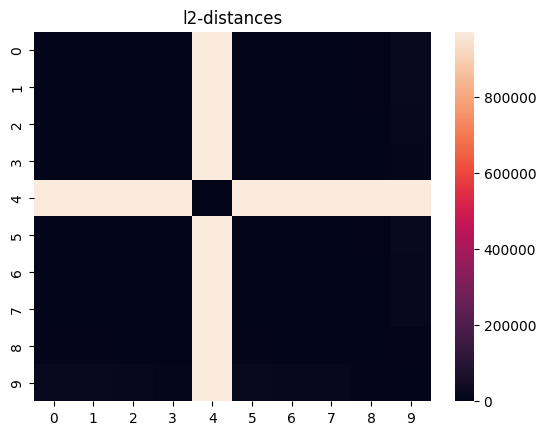

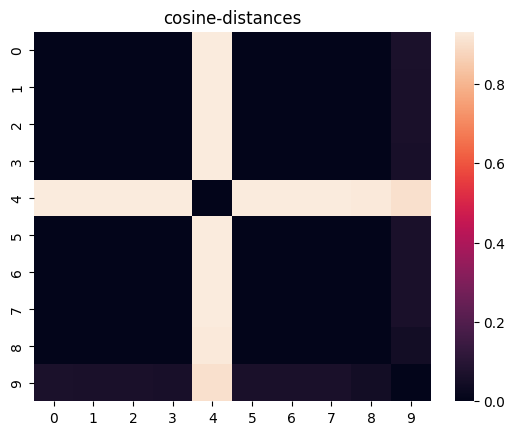

In [13]:
l2_dists = pairwise_l2_distance(all_embeddings)

rounding_constant = 10 ** 3
cos_dists = torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant

show_distance_matrix(l2_dists, "l2-distances")
show_distance_matrix(cos_dists, "cosine-distances")

what is the smallest margin?

In [14]:
def get_min_non_diagonal_entry(tensor_):
    tensor_with_inf_diag = tensor_ + torch.diag_embed(torch.ones(tensor_.shape[0], device=device) * float("inf"))
    return torch.min(tensor_with_inf_diag).item()

print(get_min_non_diagonal_entry(l2_dists))
print(get_min_non_diagonal_entry(cos_dists))

0.0003813732764683664
0.0


Contrastive loss training

Assemble graph pairs data

In [15]:
train_samples_list = []
reference_subgraph_index = 0
reference_subgraph = subgraphs[reference_subgraph_index]
negative_examples_subgraphs = subgraphs[1:]

for subgraph in subgraphs:
    if subgraph == reference_subgraph:
        is_negative_example = False
    else:
        is_negative_example = True

    G1_annotated = AnnotatedGraph(subgraph.G)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

val_samples_list = train_samples_list

Define GNN model

In [16]:
# input dim matches the node mask (w) shape
input_dim = S2VGraphEmbeddingSimilarityMetricTrainer.get_model_expected_input_dim(train_samples_list[0])
model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)

Define graph metric to train, and the trainer

In [17]:
from powerful_gnns.models.graphcnn import ParallelGraphCNN

solver_params = {
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "lr": 1e-3, "weight_decay": 1e-3,
    "max_epochs": 10000,
    "cycle_patience": 5, "step_size_up": 10, "step_size_down": 10,
    "loss_convergence_threshold": None,
    "train_loss_convergence_threshold": 1e-3,
    "successive_convergence_min_iterations_amount": 5,
    "margin_loss_margin_value": 5,
    "max_grad_norm": 0.1,
    "k_update_plot": 1,
    "batch_size": len(subgraphs),
}

problem_params = {"input_dim": input_dim}

dump_base_path = f".{os.sep}runlogs"

def init_embedding_net_and_trainer(model, device_ids, min_samples_per_batch=512):

    loss_fun = torch.nn.MSELoss()
    embedding_metric_network = EmbeddingMetricNetwork(loss_fun=loss_fun)

    parallel_model = ParallelGraphCNN(model, min_samples_per_batch=min_samples_per_batch, device_ids=device_ids)
    gnn_embedding_nn = GNNEmbeddingNetwork(gnn_model=parallel_model)

    # embedding_nns = \
    #     [
    #         GNNEmbeddingNetwork(gnn_model=model),
    #     ]

    graph_metric_nn = S2VGraphEmbeddingGraphMetricNetwork(embedding_network=gnn_embedding_nn,
                                           embdding_metric_network=embedding_metric_network,
                                           device=device)

    # graph_metric_nn = SingleEmbeddingGraphMetricNetwork(embedding_network=embedding_nns[0],
    #                                        embdding_metric_network=embedding_metric_network,
    #                                        device=device)

    # graph_metric_nn = MLPGraphMetricNetwork(embedding_networks=embedding_nns,
    #                                         embdding_metric_network=embedding_metric_network,
    #                                         device=device)


    trainer = S2VGraphEmbeddingSimilarityMetricTrainer(graph_metric_nn, dump_base_path,
                                      problem_params, solver_params)

    return trainer, graph_metric_nn

trainer, graph_metric_nn = init_embedding_net_and_trainer(model, [0])

Train

In [18]:
len(train_samples_list)

10

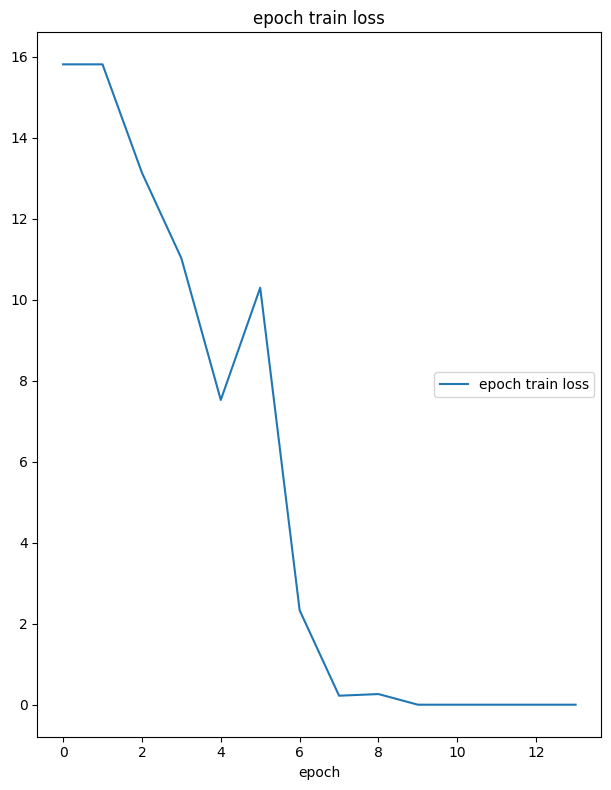

epoch train loss
	epoch train loss 	 (min:    0.000, max:   15.814, cur:    0.000)


([15.814460754394531,
  15.81446647644043,
  13.137425422668457,
  11.025169372558594,
  7.526252269744873,
  10.297775268554688,
  2.3311500549316406,
  0.22211211919784546,
  0.2626192271709442,
  1.0001592887221022e-09,
  1.0000861250247794e-09,
  1.0001099948198089e-09,
  1.0001955930150075e-09,
  1.0001992567509888e-09],
 [15.814462661743164,
  13.137421607971191,
  11.025167465209961,
  7.526249408721924,
  10.297779083251953,
  2.331148624420166,
  0.22211267054080963,
  0.2626192271709442,
  1.0002517703000535e-09,
  1.0000962280543035e-09,
  1.0001918182567238e-09,
  1.0001418582206156e-09,
  1.0001423023098255e-09,
  1.0001156569572345e-09])

In [19]:
trainer.train(use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

# classes: 1
# maximum node tag: 48
# data: 10


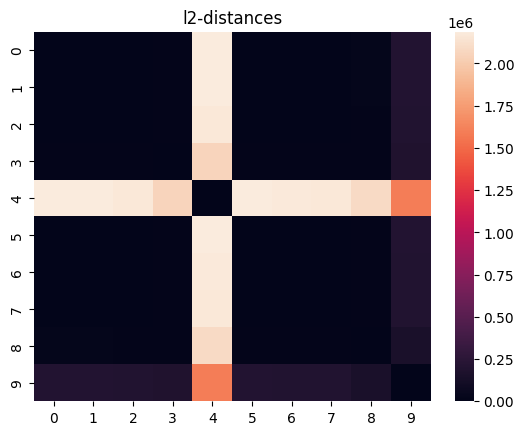

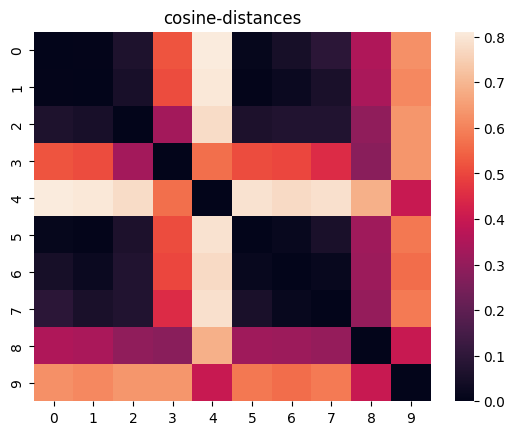

Off matrix diagonal margin: 10.695091247558594
Off matrix diagonal margin: 0.004000000189989805


In [20]:
def show_distances_heatmap(graphs, model):

    model.eval()
    all_embeddings = model.get_embedding(graphs)

    l2_dists = pairwise_l2_distance(all_embeddings)

    rounding_constant = 10 ** 3
    cos_dists = torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant

    show_distance_matrix(l2_dists, "l2-distances")
    show_distance_matrix(cos_dists, "cosine-distances")
    print(f"Off matrix diagonal margin: {get_min_non_diagonal_entry(l2_dists)}")
    print(f"Off matrix diagonal margin: {get_min_non_diagonal_entry(cos_dists)}")

show_distances_heatmap(generate_s2v_graphs([graph.g for graph in graphs]), model)

Add ged=1 examples as positive examples

In [21]:
def generate_perturbed_graphs(reference_graph: nx.Graph):
    # assumption: there are no self loops, and no duplicate edges of opposite directions

    # graphs generated by removing an existing edge
    for edge in reference_graph.edges:
        copy_graph = reference_graph.copy()
        copy_graph.remove_edge(*edge)
        yield copy_graph

    # graphs generated by adding a missing edge
    sorted_nodes = sorted(reference_graph.nodes, reverse=False)
    for i, node_i in enumerate(sorted_nodes):
        if i == len(sorted_nodes) - 1:
            break

        for node_j in sorted_nodes[i+1:]:
            edge = (node_i, node_j)
            if reference_graph.has_edge(*edge):
                continue
            copy_graph = reference_graph.copy()
            copy_graph.add_edge(*edge)
            yield copy_graph

# generate subgraphs for which ged(subgraph, reference_subgraph)==1
perturbed_graphs = list(generate_perturbed_graphs(reference_subgraph.G_sub))
for perturbed_graph in perturbed_graphs:
    is_negative_example = False

    G1_annotated = AnnotatedGraph(perturbed_graph)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

In [22]:
len(train_samples_list)

101

In [23]:
val_samples_list = train_samples_list
model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)
solver_params["batch_size"] = len(train_samples_list)

trainer, graph_metric_nn = init_embedding_net_and_trainer(model, [0])

trainer.train(use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

KeyboardInterrupt: 

# classes: 1
# maximum node tag: 49
# data: 101


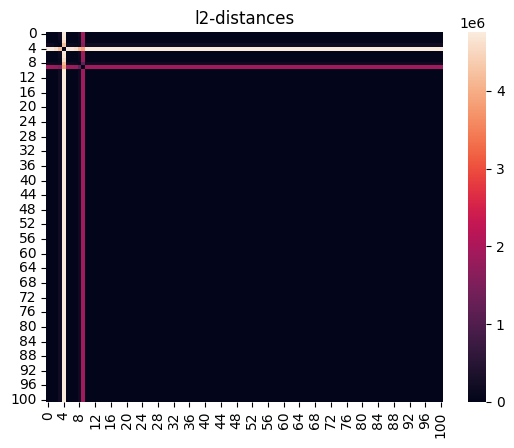

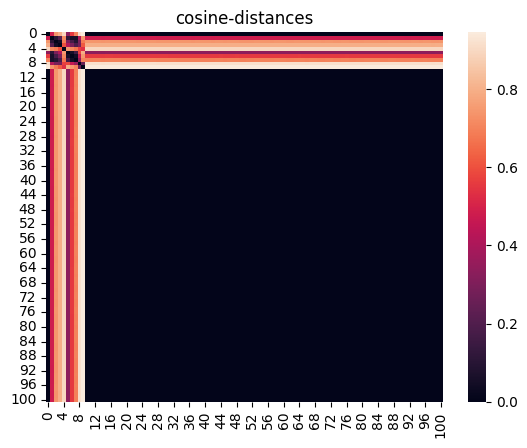

Off matrix diagonal margin: 1.3145040611561853e-13
Off matrix diagonal margin: 0.0


In [24]:
all_s2v_graphs = generate_s2v_graphs([subgraph.G for subgraph in subgraphs] + perturbed_graphs)
show_distances_heatmap(all_s2v_graphs, model)

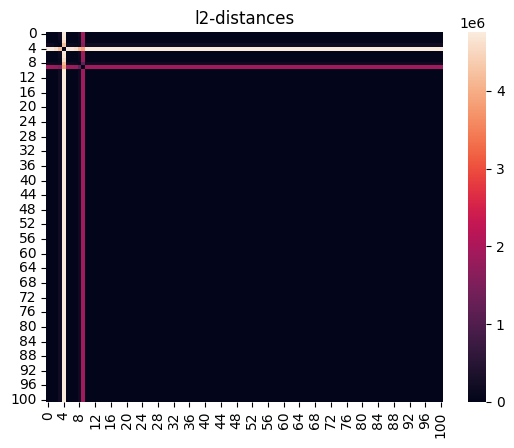

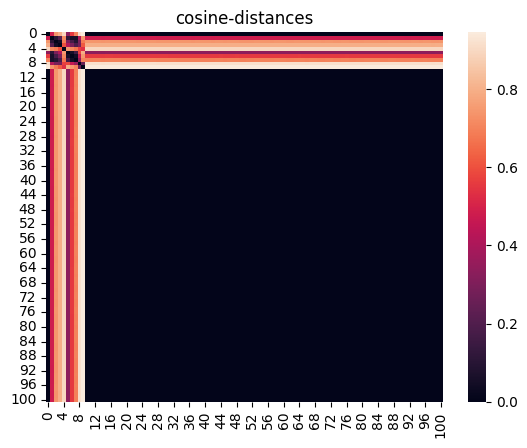

Off matrix diagonal margin: 1.3145040611561853e-13
Off matrix diagonal margin: 0.0


In [25]:
show_distances_heatmap(all_s2v_graphs, model)

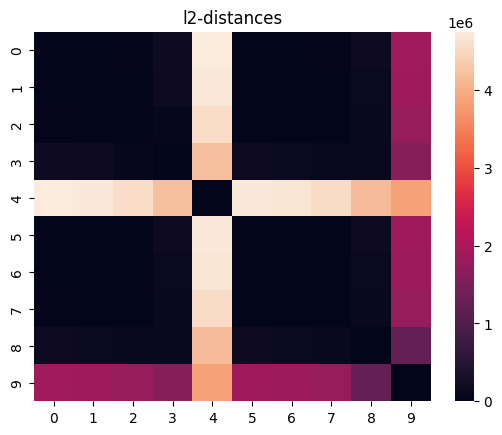

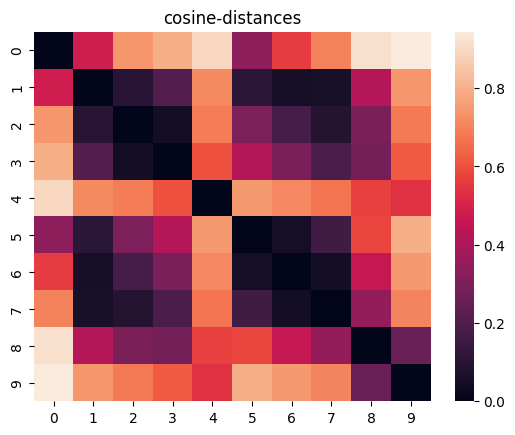

Off matrix diagonal margin: 301.6646728515625
Off matrix diagonal margin: 0.04500000178813934


In [26]:
show_distances_heatmap(all_s2v_graphs[:len(subgraphs)], model)

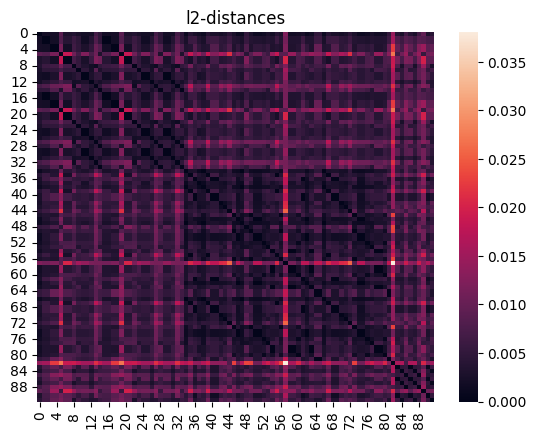

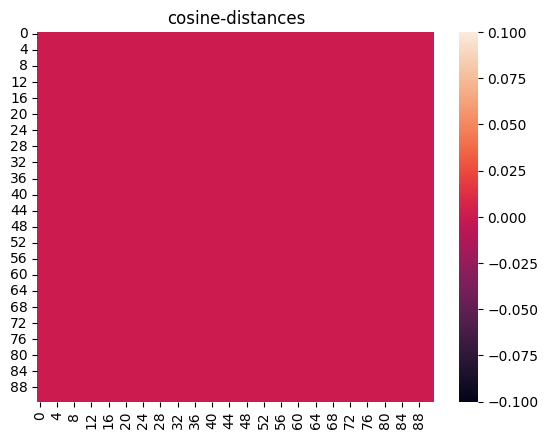

Off matrix diagonal margin: 1.3145040611561853e-13
Off matrix diagonal margin: 0.0


In [27]:
reference_s2v_graph = all_s2v_graphs[reference_subgraph_index]
reference_graph_with_positive_examples = [reference_s2v_graph] + all_s2v_graphs[len(subgraphs):]
reference_graph_with_negative_examples = [all_s2v_graphs[i] for i in range(len(all_s2v_graphs[:len(subgraphs)])) if i != reference_subgraph_index]

show_distances_heatmap(reference_graph_with_positive_examples, model)

In [28]:
all_embeddings = model.get_embedding(reference_graph_with_positive_examples)
l2_dists = pairwise_l2_distance(all_embeddings)

In [29]:
model.eval()

GraphCNN(
  (mlps): ModuleList(
    (0): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (batch_norms): ModuleList(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1-3): 3 x MLP(
      (linears): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (batch_norms): ModuleList(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (batch_norms): ModuleList(
    (0-3): 4 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linears_prediction): ModuleList(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1-4): 4 x Linear(in_features=64, out_features=2, bias=True)
  )
)

In [30]:
positive_distances = []
for positive_example_second_graph in reference_graph_with_positive_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, positive_example_second_graph)]).item()
    positive_distances.append(distance)
    if distance > solver_params['margin_loss_margin_value']:
        print(f"positive loss term not zero, as distance for this positive example pair is {distance}")

negative_distances = []
for negative_example_second_graph in reference_graph_with_negative_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, negative_example_second_graph)]).item()
    negative_distances.append(distance)
    if distance < solver_params['margin_loss_margin_value']:
        print(f"negative loss term not zero, as distance for this negative example pair is {distance}")

In [31]:
max(positive_distances)

0.00022168713621795177

In [32]:
min(negative_distances)

7.290713310241699

k-subgraphs experiment

In [33]:
def generate_pair_example(G1_annotated, G2_annotated, is_negative_example):
    return Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example))

def compare_graphs_and_generate_pair_example(G1_annotated, G2_annotated):
    SG1 = G1_annotated.g
    SG2 = G2_annotated.g

    if nx.is_isomorphic(SG1, SG2):
        isomorphic_pairs.append((SG1, SG2))
        return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = False)
    else:
        return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = True)
    
    # try:
    #     diff_graph = nx.symmetric_difference(SG1, SG2)
    # except NetworkXError:
    #     # node sets are different
    #     if nx.is_empty(SG1) and nx.is_empty(SG2) and (len(SG1) == len(SG2)):
    #         # positive example
    #         print("node sets are different, but isomorphic graphs")
    #         return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = False)
    #     else:
    #         # negative example
    #         print("node sets are different, and not isomorphic graphs")
    #         return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = True)

    # if nx.is_empty(diff_graph):
    #     # print("isomorphic graphs")
    #     isomorphic_pairs.append((SG1, SG2))
    #     # positive example
    #     return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = False)
    # else:
    #     # negative example
    #     return generate_pair_example(G1_annotated, G2_annotated, is_negative_example = True)

K = 11
full_graph = reference_subgraph.G

subgraphs_iterator = itertools.combinations(full_graph, K)
k_subgraphs = [full_graph.subgraph(s) for s in subgraphs_iterator]
k_subgraph_annotated_graphs = [AnnotatedGraph(g) for g in k_subgraphs]

train_samples_list = []
isomorphic_pairs = []
train_sample_indices_tuple_list = []

In [34]:
for subgraph_counter1, SG_annotated_1 in enumerate(k_subgraph_annotated_graphs):
    for subgraph_counter2 in range(subgraph_counter1+1, len(k_subgraph_annotated_graphs)):
        SG_annotated_2 = k_subgraph_annotated_graphs[subgraph_counter2]
        train_samples_list.append(compare_graphs_and_generate_pair_example(SG_annotated_1, SG_annotated_2))
        train_sample_indices_tuple_list.append((subgraph_counter1, subgraph_counter2))
        # if train_samples_list[-1].is_negative_sample == False:
        #     print(f"{subgraph_counter1} vs {subgraph_counter2}")

In [35]:

# k_subgraph_to_perturbed_graphs_map = {}
#
# #TODO: some problem with the space, as SG1 can be non isomorphic to SG2_perturbed, but SG2_perturbed can be a perturbation of SG1, no?
#
# # generate subgraphs for which GED==1
# for subgraph_counter1, SG1 in enumerate(k_subgraphs):
#     perturbed_graphs = list(generate_perturbed_graphs(SG1))
#     for perturbed_graph in perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, perturbed_graph, is_negative_example = False))
#     k_subgraph_to_perturbed_graphs_map[SG1] = perturbed_graphs
#
# # generate all pairs examples
# for SG1, SG1_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#     for SG2, SG2_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#
#         if SG1 == SG2:
#             continue # trivial pairs, or pairs already considered
#
#         for SG2_perturbed_graph in SG2_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1, SG2_perturbed_graph))
#
#         for SG1_perturbed_graph in SG1_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1_perturbed_graph, SG2))

In [36]:
for k_subgraph in k_subgraphs:
    if k_subgraphs[0].nodes == k_subgraph.nodes:
        print("yes")


yes


In [37]:
len(k_subgraphs)

364

In [38]:
len(train_samples_list)

66066

check 1-WL distance

In [39]:
import wwl
from wwl import WL_metric
from igraph import Graph
from igraph import Graph
from sklearn.metrics.pairwise import laplacian_kernel

def get_graph_wl_distances(graphs, node_label):
    igraphs = [Graph() for i in range(len(graphs))]
    igraphs = [igraph.from_networkx(graph) for igraph, graph in zip(igraphs, graphs)]
    kernel_values = wwl.pairwise_wasserstein_distance(igraphs, [len(igraphs)-1], enforce_continuous=True, num_iterations=10)
    kernel_values = laplacian_kernel(kernel_values) #normalize energey

    # gk_wl = WL_metric.GK_WL()
    # kernel_values = gk_wl.compare_list(graphs, h=5, node_label=node_label)
    return 1- kernel_values
    #return np.round(1 - kernel_values, decimals=4)

In [40]:
# optimized single call for WL distance calculation
### NOTE: Wl dist is not stable (depends which batch of graph you applied it with) ###
wl_dist_matrix = get_graph_wl_distances(k_subgraphs, node_label=False)

Enforce continous flag is on, using CONTINUOUS propagation scheme.


In [41]:
negative_pairs_wl_distances = []
positive_pairs_wl_distances = []

positive_pairs_index_to_dist_map = {}
negative_pairs_index_to_dist_map = {}

for i, train_sample in enumerate(train_samples_list):
    is_negative_sample = train_sample.is_negative_sample
    graph1 = train_sample.subgraph
    graph2 = train_sample.masked_graph

    # s2v_graphs = generate_s2v_graphs([graph1.g, graph2.g], print_stats=False)

    # distance = graph_metric_nn.forward([(s2v_graphs[0], s2v_graphs[1])]).item()

    # wl_dist = get_graph_wl_distances([graph1.g, graph2.g], node_label=False)[0][1]

    graph1_index, graph2_index = train_sample_indices_tuple_list[i]
    wl_dist = wl_dist_matrix[graph1_index][graph2_index]
    wl_dist = round(wl_dist, 6)
    
    if is_negative_sample:
        negative_pairs_wl_distances.append(wl_dist)
        negative_pairs_index_to_dist_map[i] = wl_dist
    else:
        positive_pairs_wl_distances.append(wl_dist)
        positive_pairs_index_to_dist_map[i] = wl_dist

In [42]:
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histogram(sequence, x_title=""):
    fig, ax = plt.subplots(1)
    sns.histplot(sequence, bins='auto', stat='density',
                 label='Normalized Histogram', ax=ax)
    
    # Fit a distribution to the data
    mu, std = norm.fit(sequence)
    x = np.linspace(min(sequence), max(sequence), 100)
    if not np.all(x == x[0]):
        y = norm.pdf(x, mu, std)
    else:
        y = np.ones_like(x)
    sns.lineplot(x=x, y=y, color='red', label='Fitted Normal Distribution', ax=ax)
    
    # Plot the KDE
    sns.kdeplot(sequence, label='KDE', bw_adjust=0.5, ax=ax)
    
    ax.set_xlabel(x_title)
    ax.set_ylabel('Density')
    ax.set_title(f'{x_title} Distribution')
    ax.legend(loc='upper left')
    ax.grid(True)
    plt.show()

In [43]:
len(positive_pairs_wl_distances)

1401

/tmp/ipykernel_3801909/4097325502.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(sequence, label='KDE', bw_adjust=0.5, ax=ax)


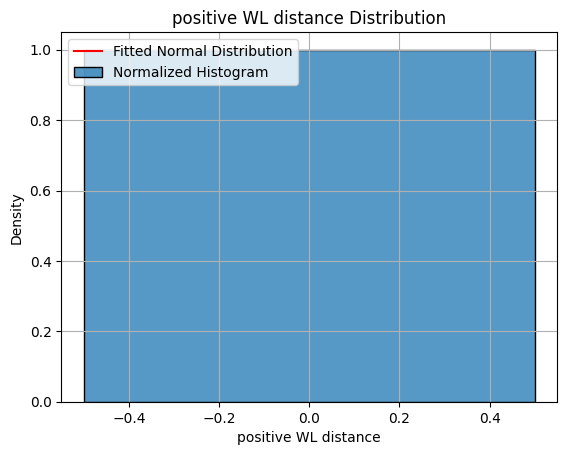

In [44]:
plot_histogram(positive_pairs_wl_distances, "positive WL distance")

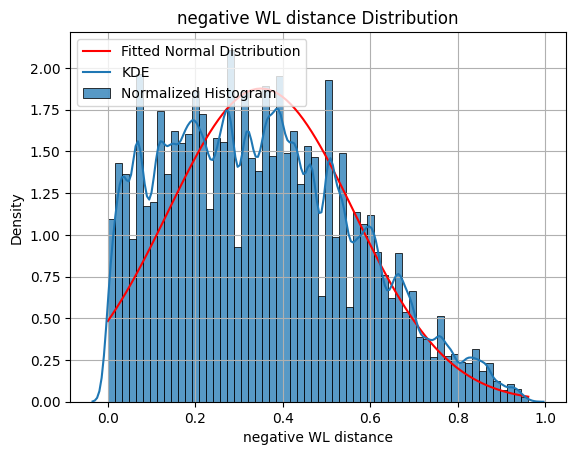

In [45]:
plot_histogram(negative_pairs_wl_distances, "negative WL distance")

In [46]:
# cnt = 0
# for i, dist in negative_pairs_index_to_dist_map.items():
#     if dist < 0.13:
#         print(i)

In [47]:
from subgraph_matching_via_nn.training.MarginLoss import MarginLoss
def calc_margin_loss(distances, pos_labels, margin):
    negative_labels = 1 - pos_labels
    lossCriterion = MarginLoss(margin)
    pos_loss, neg_loss = lossCriterion.get_loss(distances, pos_labels, negative_labels)
    print(pos_loss.sum().item())
    print(neg_loss.sum().item())

margin = 0.001
calc_margin_loss(torch.tensor(positive_pairs_wl_distances+negative_pairs_wl_distances), torch.cat((torch.ones(len(positive_pairs_wl_distances)), torch.zeros(len(negative_pairs_wl_distances)))), margin)

0.0
1.4266714000000003e-05


Fit GNN on k subgraph pairs

In [48]:
# disable debugging overhead operations
torch.autograd.set_detect_anomaly(mode=False)

In [49]:
solver_params['margin_loss_margin_value'] = 0.1

In [52]:
used_train_samples_list = train_samples_list[:10_000] #Needed due to performance issues

In [55]:
val_samples_list = used_train_samples_list
model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)
solver_params["batch_size"] = 512 * 4 #2048 #1024 #512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-6
trainer, graph_metric_nn = init_embedding_net_and_trainer(model, device_ids=[0, 1, 2, 3, 4], min_samples_per_batch=512)

trainer.train(use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=val_samples_list)

Data loaders were built
dump path: ./runlogs/1701547472.3848019
Batch #0
Batch #1
Batch #2
Batch #3
Batch #4


KeyboardInterrupt: 

Train again without rebuilding data loaders

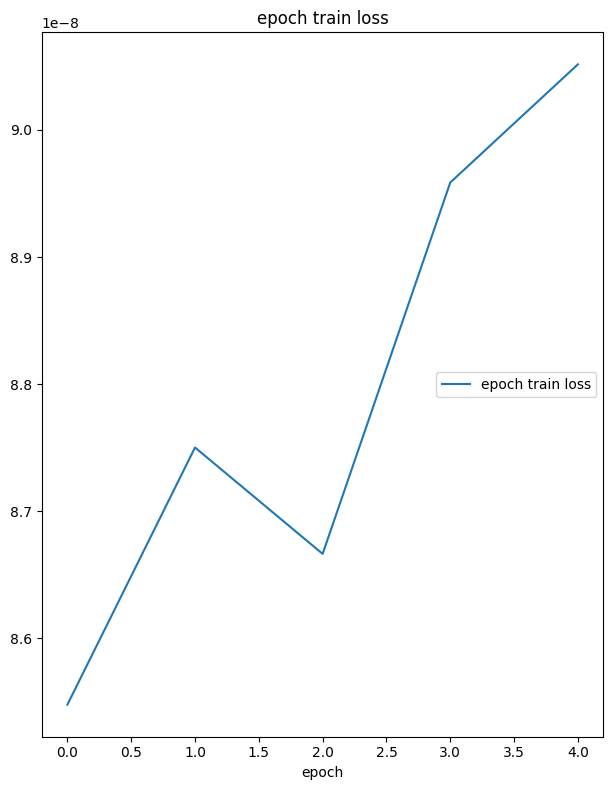

epoch train loss
	epoch train loss 	 (min:    0.000, max:    0.000, cur:    0.000)


([8.547755214749486e-08,
  8.750116364808491e-08,
  8.666424378134252e-08,
  8.958592445651448e-08,
  9.051572646967543e-08],
 [8.650565774814822e-08,
  8.624211034202744e-08,
  8.722759048396256e-08,
  8.7944478366353e-08,
  9.357316343994171e-08])

In [56]:
model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)
new_trainer, graph_metric_nn = init_embedding_net_and_trainer(model, device_ids=[0, 1, 2, 3, 4], min_samples_per_batch=512)
new_trainer.previous_train_loader = trainer.previous_train_loader
new_trainer.previous_val_loader = trainer.previous_val_loader
new_trainer.train(use_existing_data_loaders=True)

In [57]:
model.eval()
for i in range(0, len(train_samples_list)):
    is_negative_sample = train_samples_list[i].is_negative_sample
    graph1 = train_samples_list[i].subgraph
    graph2 = train_samples_list[i].masked_graph

    s2v_graphs = generate_s2v_graphs([graph1.g, graph2.g], print_stats=False)

    distance = graph_metric_nn.forward([(s2v_graphs[0], s2v_graphs[1])]).item()

    if is_negative_sample and (distance < solver_params['margin_loss_margin_value']):
        print(f"negative loss term not zero, as distance for this negative example pair is {distance}")
    if (not is_negative_sample) and (distance > solver_params['margin_loss_margin_value']):
        print(f"negative loss term not zero, as distance for this positive example pair is {distance}")